In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import sys

# from scipy.stats import multivariate_normal
from scipy.ndimage import gaussian_filter
from ipywidgets import interact, interactive, HBox, VBox, Layout
from IPython.display import display
import itertools

root_dir = Path.cwd().parents[1]
if not root_dir in sys.path:
    sys.path.insert(0, str(root_dir))

from turnover_dynamics.orientation_detection.utils import (
    gabor_filter,
    gabor_rate_response,
    sine_grating,
)

# %matplotlib ipympl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# get_ipython().kernel.do_shutdown(restart=True)
%matplotlib widget
# %matplotlib --list

interactive(children=(FloatSlider(value=0.5235987755982988, description='theta', max=3.141592653589793, step=0…

interactive(children=(FloatSlider(value=0.0, description='theta', max=3.141592653589793, step=0.01), FloatSlid…

/tmp/ipykernel_219983/652863966.py:291: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


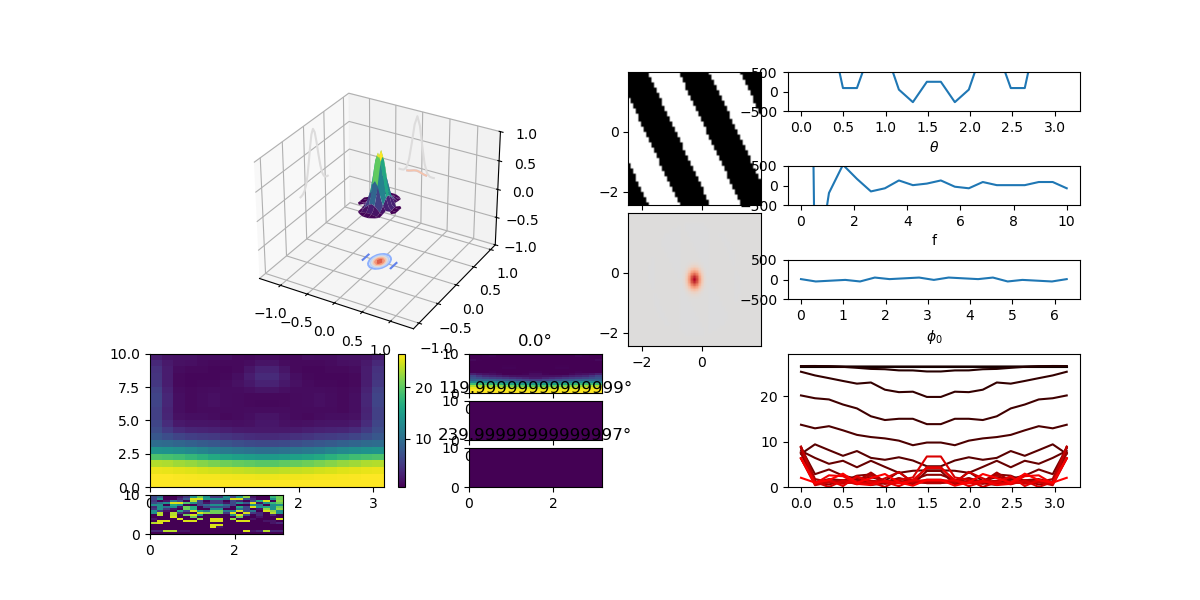

In [3]:
from turnover_dynamics.orientation_detection.utils.utils_model import softplus


steps_FoV = 51

stimulus_range = [-np.deg2rad(140), np.deg2rad(114)]
X_FoV, Y_FoV = np.meshgrid(
    np.linspace(-stimulus_range[0] / 2, stimulus_range[0] / 2, steps_FoV),
    np.linspace(-stimulus_range[1] / 2, stimulus_range[1] / 2, steps_FoV),
)

plt.close("all")
with plt.ioff():
    # fig, ax = plt.subplots(1,1)
    fig = plt.figure(figsize=(12, 6))

gs = fig.add_gridspec(10, 6)

ax_filter = fig.add_subplot(gs[:6, :3], projection="3d")
ax_grating = fig.add_subplot(gs[:3, 3])
ax_combined = fig.add_subplot(gs[3:6, 3])

axx = {
    "theta": fig.add_subplot(gs[0, 4:]),
    "f": fig.add_subplot(gs[2, 4:]),
    "phi_0": fig.add_subplot(gs[4, 4:]),
}
ax_optimal_response = fig.add_subplot(gs[6:9, :2])
ax_responses = fig.add_subplot(gs[6:9, 4:])
ax_optimal_phase = fig.add_subplot(gs[9, 0])

ax_response_at_phi = []
for i in range(3):
    ax_response_at_phi.append(fig.add_subplot(gs[6 + i, 2]))


grating = sine_grating(X_FoV, Y_FoV, np.deg2rad(20.0), 1, 0.0, square=True)
img_grating = ax_grating.imshow(
    grating,
    extent=[stimulus_range[0], stimulus_range[1], stimulus_range[0], stimulus_range[1]],
    cmap="gray",
)

G = gabor_filter(X_FoV, Y_FoV, A=1, sigma=1.0, f=1, theta=np.deg2rad(20.0))
# img_filter = ax_filter.imshow(
#     G, extent=[-5, 5, -5, 5], cmap="gray", clim=[-1, 1]
# )  # , levels=50, cmap="RdBu_r")
img_filter = ax_filter.plot_surface(X_FoV, Y_FoV, G)
ax_filter.set_zlim([-1, 1])

img_combined = ax_combined.imshow(
    G * grating,
    extent=[stimulus_range[0], stimulus_range[1], stimulus_range[0], stimulus_range[1]],
    cmap="coolwarm",
    clim=[-1, 1],
)  # , levels=50, cmap="RdBu_r")


axx["theta"].set_xlabel("$\\theta$")
axx["f"].set_xlabel("f")
axx["phi_0"].set_xlabel("$\\phi_0$")


steps = {"theta": 20, "f": 20, "phi_0": 19}
arrays = {
    "theta": np.linspace(0, np.pi, steps["theta"]),
    "f": np.linspace(0, 10, steps["f"]),
    "phi_0": np.linspace(0, 2 * np.pi, steps["phi_0"]),
}

responses = {
    "theta": np.zeros(steps["theta"]),
    "f": np.zeros(steps["f"]),
    "phi_0": np.zeros(steps["phi_0"]),
}

lines = {}
(lines["theta"],) = axx["theta"].plot(arrays["theta"], responses["theta"])
(lines["f"],) = axx["f"].plot(arrays["f"], responses["f"])
(lines["phi_0"],) = axx["phi_0"].plot(arrays["phi_0"], responses["phi_0"])

filter_interactive = interactive(lambda x: x, x=10)
grating_interactive = interactive(lambda x: x, x=10)


def update_grating(
    theta=np.deg2rad(30),
    f=1.0,
    phi_0=0,
    square=True,
):

    grating = sine_grating(X_FoV, Y_FoV, theta, f, phi_0, square=square)
    img_grating.set_data(grating)

    G = filter_interactive.result

    ## for different gratings, calculate overall response (sum)
    for key in ["theta", "f", "phi_0"]:

        params = {"theta": theta, "f": f, "phi_0": phi_0}

        for i, value in enumerate(arrays[key]):
            params[key] = value
            grating_ = sine_grating(
                X_FoV,
                Y_FoV,
                params["theta"],
                params["f"],
                params["phi_0"],
                square=square,
            )
            responses[key][i] = (G * grating_).sum()
        lines[key].set_ydata(responses[key])

    # min = np.min([response_theta.min(), response_f.min(), response_phi.min()]) * 1.1
    # max = np.max([response_theta.max(), response_f.max(), response_phi.max()]) * 1.1
    for ax in axx.values():
        # ax.set_ylim([min,max])
        ax.set_ylim([-500, 500])

    update_combined(G, grating)

    return grating


# steps_phi = 19
# array_phi = np.linspace(0,360,steps_phi)


img_optimal_phase = ax_optimal_phase.imshow(
    np.random.rand(steps["theta"], steps["f"]),
    extent=[0, arrays["theta"].max(), 0, arrays["f"].max()],
    origin="lower",
    aspect="auto",
    cmap="viridis",
    clim=[0, 2 * np.pi],
)

img_optimal_response = ax_optimal_response.imshow(
    np.random.rand(steps["theta"], steps["f"]),
    extent=[0, arrays["theta"].max(), 0, arrays["f"].max()],
    origin="lower",
    aspect="auto",
    cmap="viridis",
)
plt.colorbar(img_optimal_response)

img_response_at_phi = []
for i in range(3):
    img_response_at_phi.append(
        ax_response_at_phi[i].imshow(
            np.random.rand(steps["theta"], steps["f"]),
            extent=[0, arrays["theta"].max(), 0, arrays["f"].max()],
            origin="lower",
            aspect="auto",
            cmap="viridis",
        )
    )
    ax_response_at_phi[i].set_title(
        f"{np.rad2deg(arrays['phi_0'][i * (steps['phi_0'] // 3)])}°"
    )
    # plt.colorbar(img_optimal_response)

response_lines = []
for i in range(steps["f"]):
    (line,) = ax_responses.plot(
        arrays["theta"], np.zeros(steps["theta"]), color=[(i + 1) / steps["f"], 0, 0]
    )
    response_lines.append(line)


Theta, F = np.meshgrid(arrays["theta"], arrays["f"])


gratings = np.zeros((steps["phi_0"], steps["theta"], steps["f"], steps_FoV, steps_FoV))

for prod in itertools.product(
    enumerate(arrays["phi_0"]), enumerate(arrays["theta"]), enumerate(arrays["f"])
):
    idx, elems = zip(*prod)
    phi_0, theta, f = elems

    gratings[*idx] = sine_grating(X_FoV, Y_FoV, theta, f, phi_0, square=True)


def update_filter(
    theta=0,
    theta_gauss=0,
    f=1.0,
    sigma=0.1,
    gamma=1.0,
    phi_0=0.0,
    update_phase=True,
):

    G = gabor_filter(
        X_FoV,
        Y_FoV,
        A=1,
        theta=theta,
        theta_gauss=theta_gauss,
        f=f,
        sigma=sigma,
        gamma=gamma,
        phi_0=phi_0,
    )

    ax_filter.clear()

    G_plot = np.copy(G)
    G_plot[np.abs(G) < G.max() * 0.001] = np.nan
    ax_filter.plot_surface(X_FoV, Y_FoV, G_plot, cmap="viridis")
    ax_filter.contour(X_FoV, Y_FoV, G_plot, zdir="z", offset=-1, cmap="coolwarm")
    ax_filter.contour(
        X_FoV, Y_FoV, G_plot, zdir="x", offset=X_FoV.min(), cmap="coolwarm"
    )
    ax_filter.contour(
        X_FoV, Y_FoV, G_plot, zdir="y", offset=Y_FoV.max(), cmap="coolwarm"
    )
    ax_filter.set_zlim([-1, 1])
    # img_filter.set_data(G)
    update_combined(G, grating_interactive.result)

    if update_phase:
        # calculate response for entire 3D-grid and find optimal phi_0 for each theta and f
        response = np.tensordot(G, gratings, axes=([0, 1], [3, 4]))
        response_fr = softplus(response, 1, 0)

        optimal_idx = np.argmax(response, axis=0)
        optimal_phi_0 = arrays["phi_0"][optimal_idx]
        optimal_response = np.max(response, axis=0)

        for i, line in enumerate(response_lines):
            line.set_ydata(optimal_response[:, i])
        ax_responses.set_ylim([0, optimal_response.max() * 1.1])

        img_optimal_phase.set_data(optimal_phi_0.T)
        img_optimal_response.set_data(gaussian_filter(optimal_response, (1, 1)).T)
        clims = np.percentile(optimal_response, [5, 95])
        img_optimal_response.set_clim(clims)

        for i, img in enumerate(img_response_at_phi):
            phase_idx = i * (steps["phi_0"] // 3)
            img.set_data(gaussian_filter(response[phase_idx, ...], (1, 1)).T)
            # img.set_data(gaussian_filter(response_fr[phase_idx, ...], (1, 1)).T)
            img.set_clim(clims)

    return G


def update_combined(G, grating):
    img_combined.set_data(G * grating)


grating_interactive = interactive(
    update_grating,
    theta=(0, arrays["theta"][-1], 0.01),
    f=(0, arrays["f"][-1], 0.01),
    phi_0=(0, 2 * np.pi, 0.01),
    square=True,
)

filter_interactive = interactive(
    update_filter,
    theta=(0, arrays["theta"][-1], 0.01),
    theta_gauss=(0, arrays["theta"][-1], 0.01),
    f=(0, arrays["f"][-1], 0.1),
    sigma=(0.01, 1, 0.01),
    gamma=(0.1, 4, 0.1),
    phi_0=(0, 2 * np.pi, 0.01),
    update_phase=True,
)

display(grating_interactive)
display(filter_interactive)


# VBox(
#     [
#         HBox(
#             [grating_interactive, filter_interactive],
#             layout=Layout(width="100%", display="flex", align_items="center"),
#         ),
#         fig.canvas,
#     ],
#     layout=Layout(width="60%", display="flex", align_items="center"),
# )
# ax_responses.colorbar()

plt.tight_layout()
plt.show()

In [33]:
visual_range = [np.deg2rad(140), np.deg2rad(114)]
FoV_steps = 51
X_FoV, Y_FoV = np.meshgrid(
    np.linspace(-visual_range[0] / 2, visual_range[0] / 2, FoV_steps),
    np.linspace(-visual_range[1] / 2, visual_range[1] / 2, FoV_steps),
)

gabor_params = {
    "theta": np.deg2rad(20.0),
    "f": 1,
    "sigma": 1.0,
    "gamma": 2.0,
    "phi_0": np.deg2rad(0.0),
    "theta_gauss": None,
}
G = gabor_filter(X_FoV, Y_FoV, **gabor_params)
# G.mean()
## normalization gabor & grating

stim_params = {
    "theta": np.deg2rad(20.0),
    "f": 1,
    "phi_0": np.deg2rad(0.0),
    "square": False,
}
grating = sine_grating(X_FoV, Y_FoV, **stim_params)
rate = gabor_rate_response(X_FoV, Y_FoV, gabor_params, grating)
rate

0.02011640692342127 0.2981016182408732
1.3659029906960788e-18 0.629606044339188


np.float64(605.8931413735263)

In [ ]:
string = ""
# steps = {"theta": 18, "f": 10, "phi_0": 3}
# print(steps)
# gratings = np.zeros((steps["phi_0"], steps["theta"], steps["f"], FoV_steps, FoV_steps))
# gratings = np.zeros((FoV_steps, FoV_steps))

for i in range(len(gratings.shape) - 2):
    string += chr(ord("a") + i)

string

einstein_string = f"ij,{string}ij->{string}"
einstein_string

{'theta': 18, 'f': 10, 'phi_0': 3}


'ij,ij->'

In [34]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

# ----- 1. FFT of RF -----
dx = dy = 1.0

G = gabor_filter(X_FoV, Y_FoV, **gabor_params)

Nx, Ny = G.shape

RF_fft = np.fft.fftshift(np.fft.fft2(G))
fx = np.fft.fftshift(np.fft.fftfreq(Nx, d=dx))
fy = np.fft.fftshift(np.fft.fftfreq(Ny, d=dy))

interp_G = RegularGridInterpolator((fx, fy), RF_fft, bounds_error=False, fill_value=0.0)


def kvec(theta, f):
    return f * np.cos(theta), f * np.sin(theta)


def simple_linear_response_fft(theta, f, phi):
    kx, ky = kvec(theta, f)
    G_sample = interp_G([[kx, ky]])[0]
    return np.real(G_sample * np.exp(1j * phi))


def complex_rate_fft(theta, f):
    kx, ky = kvec(theta, f)
    G_sample = interp_G([[kx, ky]])[0]
    return np.abs(G_sample) ** 2  # up to overall gain

interactive(children=(FloatSlider(value=0.0, description='a', max=2.0, min=-2.0), FloatSlider(value=5.0, description='b', max=10.0), Output()), _dom_classes=('widget-interact',))


interactive(children=(FloatSlider(value=0.0, description='a', max=2.0, min=-2.0), FloatSlider(value=5.0, descr…

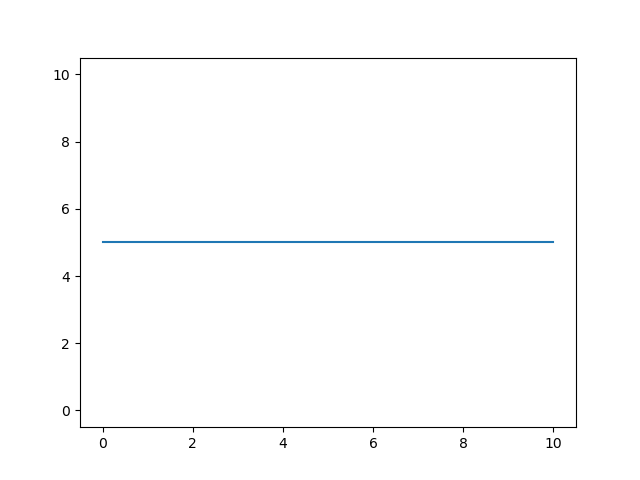

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
steps = 21

x_arr = np.linspace(0, 10, steps)
(line,) = ax.plot(x_arr, np.linspace(0, 10, steps))


def test(a, b):
    # display(a * b)
    line.set_ydata(x_arr * a + b)
    print(theta_filter.result)
    return a * b


theta_filter = interactive(test, a=(-2, 2, 0.1), b=(0, 10, 0.1))
print(theta_filter)
display(theta_filter)

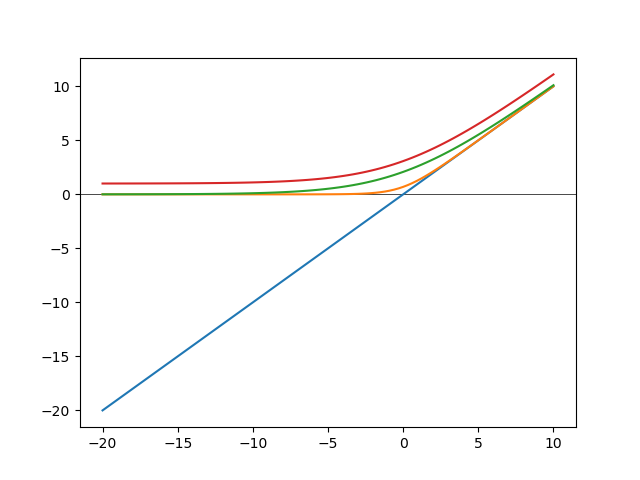

In [ ]:
from turnover_dynamics.orientation_detection.utils import (
    softplus,
    output_nonlinearity,
)

x = np.linspace(-20, 10, 100)
# y1 = softplus(x)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.axhline(0, color="k", lw=0.5)
ax.plot(x, x)
ax.plot(x, softplus(x))
# ax.plot(x, softplus(x,2.))
ax.plot(x, softplus(x, 3.0))
ax.plot(x, softplus(x, 3.0, delta=1.0))
# y2 = output_nonlinearity(x, amplitude=2.0, threshold=1.